In [1]:
# install reverse_geocoder
!pip install reverse_geocoder

# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import os

# Data 200 - Graduate Project

Gavin Chan

Andrew Gorin

Xinchen Lu



**Research Question**: Our group intends to use Topic 2: Dataset A in order to explore the relationship between a variety of weather phenomena, likely heat and precipitation anomaly, and human behavior (e.g. crime, suicide, etc). This idea was partially inspired by Solomon Hsiang and Marshall Burke’s work on such subjects (Science, 2013; Nature Climate Change, 2018). In addition to the provided datasets, we’re considering including FBI crime data on arrests.

# [INCOMPLETE]
## Data Sampling and Collection
[TODO]
1. How were the data collected?
2. Was there any potential bias introduced in the sampling process?

# [INCOMPLETE]
## Data Sampling and Collection
[TODO]
1. What type of data are you currently exploring?
2. What is the granularity of the data?
3. What does the distribution of the data look like? Are there any outliers? Are there any missing or invalid entries?

### Setup and Preprocessing

Run this on first time setup. It will create a dataset folder, download the necesarry datasets, and unzip them. 

**Note**: this make take some time to run.

In [2]:
# Run this on first time setup. It will create a dataset folder,
# download the necesarry datasets, and unzip them.

# note, this may take some time to run.
download_unzip_datasets = False

if download_unzip_datasets:
    # source from:
    # https://stackoverflow.com/questions/19602931/basic-http-file-downloading-and-saving-to-disk-in-python
    import os
    import urllib.request 
    !pip install gdown
    import pathlib
    import zipfile
    import gdown
    import shutil
    
    dataset_path = "./datasets/"
    
    # create folder if doesn't exist
    # https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory
    pathlib.Path('./datasets').mkdir(parents=True, exist_ok=True) 
    print('Created datsets folder')
    
    # get NIBRS 2020 data
    # https://stackoverflow.com/questions/20338452/saving-files-downloaded-from-urlretrieve-to-another-folder-other
    url = "https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/masters/nibrs/nibrs-2020.zip"
    file_name = os.path.join(dataset_path, "nibrs-2020.zip")
    response = urllib.request.urlretrieve(url, file_name)
    print('Downloaded NIBRS 2020')
    
    # unzip file
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print('Extracted NIBRS 2020')
    
    # get weather dataset from google drive
    # https://github.com/wkentaro/gdown
    url = "https://drive.google.com/uc?id=15pjzsCiIE0uL69a4tZYgXoog8TKjIJNJ"
    output = "./datasets/daily_global_weather_2020.csv"
    gdown.download(url, output, quiet=False)
    print('Downloaded Weather 2020 Data')

In [3]:
FBI_CRIME_2020_PATH = './datasets/2020_NIBRS_NATIONAL_MASTER_FILE_ENC.txt'
WEATHER_2020_PATH = './daily_global_weather/daily_global_weather_2020.csv'

In [4]:
# read daily 2020 weather dataset
df_daily_global_weather = pd.read_csv(WEATHER_2020_PATH)

# df_daily_global_weather.describe()
df_daily_global_weather.head(5)

,Unnamed: 0,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation
0,0,AE000041196,2020-01-01,211.0,0.0,25.333,55.5170,34.0
1,1,AEM00041194,2020-01-01,217.0,0.0,25.255,55.3640,10.4
2,2,AFM00040938,2020-01-01,54.0,23.0,34.210,62.2280,977.2
3,3,AG000060611,2020-01-01,71.0,10.0,28.050,9.6331,561.0
4,4,AGE00147708,2020-01-01,99.0,0.0,36.720,4.0500,222.0


In [5]:
# get the latitudes and longitudes from the dataframe, create each lat/long
# pair, and use reverse geocoder to get each location

latitudes = df_daily_global_weather['Latitude']
longitudes = df_daily_global_weather['Longitude']
pairs_locations = list(zip(latitudes, longitudes))
results = rg.search(pairs_locations)

Loading formatted geocoded file...


In [6]:
# create a dataframe with the results from the reverse geocoder search
df_locations = pd.DataFrame.from_dict(results)
print(df_locations.shape)

(1362814, 6)


In [7]:
# merge the geocoded locations with the weather dataset
df_daily_global_weather_location = (
    df_daily_global_weather.merge(right=df_locations,
    how="inner",
    left_index=True,
    right_index=True
    ))

In [8]:
# EDA: get the weather in California
df_daily_CA_weather = df_daily_global_weather_location[(df_daily_global_weather_location['cc'] == 'US') & (df_daily_global_weather_location['admin1'] == 'California')]
df_daily_CA_weather

,Unnamed: 0,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation,lat,lon,name,admin1,admin2,cc
3196,3196,USS0019L03S,2020-01-01,5.0,0.0,38.8500,-119.9400,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
3197,3197,USS0019L05S,2020-01-01,13.0,0.0,38.6100,-119.9200,2455.8,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
3199,3199,USS0019L07S,2020-01-01,23.0,0.0,38.3100,-119.6000,2690.5,38.25575,-119.23127,Bridgeport,California,Mono County,US
3200,3200,USS0019L08S,2020-01-01,30.0,0.0,38.3000,-119.5500,2194.0,38.25575,-119.23127,Bridgeport,California,Mono County,US
3201,3201,USS0019L13S,2020-01-01,32.0,0.0,38.0700,-119.2300,2878.8,38.25575,-119.23127,Bridgeport,California,Mono County,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362696,1362696,USW00023273,2020-12-31,97.0,3.0,34.8994,-120.4486,73.8,34.86526,-120.436,Orcutt,California,Santa Barbara County,US
1362724,1362724,USW00024216,2020-12-31,77.0,0.0,40.1519,-122.2536,107.6,40.17849,-122.23583,Red Bluff,California,Tehama County,US
1362733,1362733,USW00024257,2020-12-31,76.0,0.0,40.5175,-122.2986,151.5,40.44821,-122.29778,Anderson,California,Shasta County,US
1362756,1362756,USW00093193,2020-12-31,85.0,0.0,36.7800,-119.7194,101.5,36.79301,-119.70097,Tarpey Village,California,Fresno County,US


In [9]:
# EDA: for a particular Station, graph its daily weather over the entire year in
# a line graph

df_station = df_daily_CA_weather.loc[df_daily_CA_weather['Station'] == 'USS0019L03S']
df_station

,Unnamed: 0,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation,lat,lon,name,admin1,admin2,cc
3196,3196,USS0019L03S,2020-01-01,5.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
6987,6987,USS0019L03S,2020-01-02,-8.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
10843,10843,USS0019L03S,2020-01-03,43.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
14654,14654,USS0019L03S,2020-01-04,23.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
18306,18306,USS0019L03S,2020-01-05,-24.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347681,1347681,USS0019L03S,2020-12-27,-41.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
1351357,1351357,USS0019L03S,2020-12-28,-42.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
1355026,1355026,USS0019L03S,2020-12-29,-50.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US
1358668,1358668,USS0019L03S,2020-12-30,-24.0,0.0,38.85,-119.94,2370.1,38.93324,-119.98435,South Lake Tahoe,California,El Dorado County,US


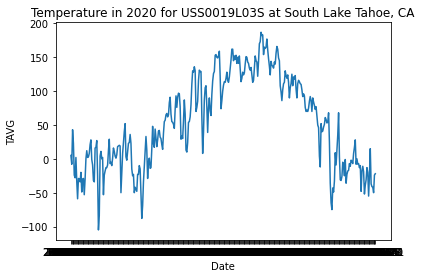

In [10]:
sns.lineplot(data=df_station, x='Date', y='TAVG')
plt.title('Temperature in 2020 for USS0019L03S at South Lake Tahoe, CA');
#TODO: overplotting of dates. Need to fix (ex. first day of every month)

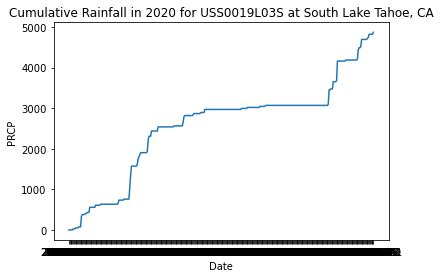

In [11]:
sns.lineplot(x=df_station['Date'], y=df_station['PRCP'].cumsum())
#TODO: overplotting of dates. Need to fix (ex. first day of every month)
plt.title('Cumulative Rainfall in 2020 for USS0019L03S at South Lake Tahoe, CA');

In [12]:
# read through each line of the FBI data and extract the line
# if it is an offence (code 02)
df_crime_data = pd.DataFrame()
input_string_arr = []
with open(FBI_CRIME_2020_PATH) as file:
    count = 0
    for line in file:
        if line[0:2] == '02':
            input_string_arr.append(line)
            count += 1

df_crime_data['input_string'] = input_string_arr
display(df_crime_data.head(5))

,input_string
0,0201AL0010700 0E055CN33EM20200312250CN 24 P...
1,0201AL0010700 1FRBJSK-TT520200225220CN 20 F ...
2,0201AL0010700 286 AUA59PJ20200320220CN 20 N ...
3,0201AL0010700 90ALHXO1G1A2020041713ACN 20 ...
4,0201AL0010700 IDBE72OFU1920200218220CN 20 F ...


In [13]:
def decode_raw_string(df):
    '''
    Split into appropriate columns
    Input: dataframe with raw string
    '''
    # segment level
    df['Segment Level'] = df['input_string'].str[0:2].astype(int)

    # state code 
    df['State Code'] = df['input_string'].str[2:4].astype(int)

    # originating agency identifier
    df['Originating Agency Identifier (ORI)'] = df['input_string'].str[4:13]

    # incident number
    df['Incident Number'] = df['input_string'].str[13:25]

    # incident date
    df['Incident Date'] = df['input_string'].str[25:33]

    # UCR offence code
    df['UCR Offense Code'] = df['input_string'].str[33:36]

    # offense attempted / completed
    df['Offense Attempted/Completed'] = df['input_string'].str[36]

    # offender suspected of using
    df['Suspected of Using 1'] = df['input_string'].str[37]
    df['Suspected of Using 2'] = df['input_string'].str[38]
    df['Suspected of Using 3'] = df['input_string'].str[39]

    # location type
    df['Location Type'] = df['input_string'].str[40:42]

    # number of premises entered
    df['Number of Premises Entered'] = df['input_string'].str[42:44]

    # method of entry
    df['Method of Entry - Force'] = df['input_string'].str[44]

    # type criminal activity
    df['Type Criminal Activity 1'] = df['input_string'].str[45]
    df['Type Criminal Activity 2'] = df['input_string'].str[46]
    df['Type Criminal Activity 3'] = df['input_string'].str[47]

    # type weapon/force involved, and automatic indicator
    df['Type Weapon/Force Involved 1'] = df['input_string'].str[48:50]
    df['Weapon 1 Automatic Indicator'] = df['input_string'].str[50]
    df['Type Weapon/Force Involved 2'] = df['input_string'].str[51:53]
    df['Weapon 2 Automatic Indicator'] = df['input_string'].str[53]
    df['Type Weapon/Force Involved 3'] = df['input_string'].str[54:56]
    df['Weapon 3 Automatic Indicator'] = df['input_string'].str[56]
    
    # bias motivation
    df['Bias Motivation'] = df['input_string'].str[57:59].astype(int)
    
    print('Finished getting substrings and converting to columns')
    
    replace_dict = {
        'UCR Offense Code' : {'200': 'Arson',
                              '13A': 'Aggravated Assault',
                              '13B': 'Simple Assault',
                              '13C': 'Intimidation',
                              '510': 'Bribery',
                              '220': 'Burglary/Breaking and Entering',
                              '250': 'Counterfeiting/Forgery',
                              '290': 'Destruction/Damage/Vandalism of Property',
                              '35A': 'Drug/Narcotic Violations',
                              '35B': 'Drug Equipment Violations',
                              '270': 'Embezzlement',
                              '210': 'Extortion/Blackmail',
                              '26A': 'False Pretenses/Swindle/Confidence Game',
                              '26B': 'Credit Card/Automatic Teller Machine Fraud',
                              '26C': 'Impersonation',
                              '26D': 'Wellfare Fraud',
                              '26E': 'Wire Fraud',
                              '39A': 'Betting/Wagering',
                              '39B': 'Operating/Promoting/Assisting Gambling',
                              '39C': 'Gambling Equipment Violations',
                              '39D': 'Sports Tampering',
                              '09A': 'Murder/Nonnegligent Manslaughter',
                              '09B': 'Negligent Manslaughter',
                              '09C': 'Justifiable Homocide',
                              '100': 'Kidnaping/Abduction',
                              '23A': 'Pocket-Picking',
                              '23B': 'Purse-snatching',
                              '23C': 'Shoplifting',
                              '23D': 'Theft From Building',
                              '23E': 'Theft from Coin-Operated Machine of Device',
                              '23F': 'Theft from Motor Vehicle',
                              '23G': 'Theft of Motor Vehicle Parts/Accessories',
                              '23H': 'All Other Larceny',
                              '240': 'Motor Vehicle Theft',
                              '370': 'Pornography/Obscene Material',
                              '40A': 'Prostitution',
                              '40B': 'Assisting or Promoting Prostitution',
                              '120': 'Robbery',
                              '11A': 'Forcible Rape',
                              '11B': 'Forcible Sodomy',
                              '11C': 'Sexual Assault With An Object',
                              '11D': 'Forcible Fondling (Incident Liberties/Child Molest)',
                              '36A': 'Incest',
                              '36B': 'Statuatory Rape',
                              '280': 'Stolen Property Offenses',
                              '520': 'Weapon Law Violations'
                              },
        'Offense Attempted/Completed': {' ': None,
                                        'A': 'Attempted',
                                        'C': 'Completed'
                                       },
        'Suspected of Using 1': {' ': None,
                                 'A': 'Alcohol',
                                 'C': 'Computer Equipment',
                                 'D': 'Drugs/Narcotics',
                                 'N': 'Not Applicable'
                                },
        'Suspected of Using 2': {' ': None,
                                 'A': 'Alcohol',
                                 'C': 'Computer Equipment',
                                 'D': 'Drugs/Narcotics',
                                 'N': 'Not Applicable'
                                },
        'Suspected of Using 3': {' ': None,
                                 'A': 'Alcohol',
                                 'C': 'Computer Equipment',
                                 'D': 'Drugs/Narcotics',
                                 'N': 'Not Applicable'
                                },
        'Location Type': {'  ': None,
                          '01': 'Air/Bus/Train Terminal',
                          '02': 'Bank/Savings and Loan',
                          '03': 'Bar/Nightclub',
                          '04': 'Church/Synagogue/Temple',
                          '05': 'Commercial/Office Building',
                          '06': 'Construction Site',
                          '07': 'Convenience Store',
                          '08': 'Department/Discount Store',
                          '09': "Drug Store/Dr.'s Office/Hospital",
                          '10': 'Field/Woods',
                          '11': 'Government/Public Building',
                          '12': 'Grocery/Supermarket',
                          '13': 'Highway/Road/Alley',
                          '14': 'Hotel/Motel/Etc.',
                          '15': 'Jail/Perison',
                          '16': 'Lake/Waterway',
                          '17': 'Liquor Store',
                          '18': 'Parking Lot/Garage',
                          '19': 'Rental Stor. Facil.',
                          '20': 'Residence/Home',
                          '21': 'Restaurant',
                          '22': 'School/College',
                          '23': 'Service/Gas Station',
                          '24': 'Sepecialty Store (TV, Fur, Etc.)',
                          '25': 'Other/Unknown'
                         },
        'Number of Premises Entered': {'  ': 0,
                                      },
        'Method of Entry - Force': {' ': None,
                                    'F': 1,
                                    'N': 0
                                   },
        'Type Criminal Activity 1':{' ': None,
                                    'B': 'Buying/Receiving',
                                    'C': 'Cultivating/Manufacturing/Publishing',
                                    'D': 'Distributing/Selling',
                                    'E': 'Exploting Children',
                                    'O': 'Operating/Promoting/Assisting',
                                    'P': 'Possessing/Concealing',
                                    'T': 'Transporting/Transmitting/Importing',
                                    'U': 'Using/Consuming'
                                   },
                    
        'Type Criminal Activity 2':{' ': None,
                                    'B': 'Buying/Receiving',
                                    'C': 'Cultivating/Manufacturing/Publishing',
                                    'D': 'Distributing/Selling',
                                    'E': 'Exploting Children',
                                    'O': 'Operating/Promoting/Assisting',
                                    'P': 'Possessing/Concealing',
                                    'T': 'Transporting/Transmitting/Importing',
                                    'U': 'Using/Consuming'
                                   },
        'Type Criminal Activity 3':{' ': None,
                                    'B': 'Buying/Receiving',
                                    'C': 'Cultivating/Manufacturing/Publishing',
                                    'D': 'Distributing/Selling',
                                    'E': 'Exploting Children',
                                    'O': 'Operating/Promoting/Assisting',
                                    'P': 'Possessing/Concealing',
                                    'T': 'Transporting/Transmitting/Importing',
                                    'U': 'Using/Consuming'
                                   },
        'Type Weapon/Force Involved 1': {'  ': None,
                                         '11': 'Firearm (type not stated)',
                                         '12': 'Handgun',
                                         '13': 'Rifle',
                                         '14': 'Shotgun',
                                         '15': 'Other Firearm',
                                         '20': 'Knife/Cutting Instrument (ice pick, screwdriver, ax, etc.)',
                                         '30': 'Blunt Object (club, hammer, etc.)',
                                         '35': 'Motor Vehicle',
                                         '40': 'Person Weapons (hands, feet, teeth, etc.)',
                                         '50': 'Poison (include gas)',
                                         '60': 'Explosives',
                                         '65': 'Fire/Incendiary Device',
                                         '70': 'Drugs/Narcotics/Sleeping Pills',
                                         '85': 'Asphyxiation (by drowning, strangulation, suffocation, gas, etc.)',
                                         '90': 'Other',
                                         '95': 'Unknown',
                                         '99': 'None'
                                         },
        'Weapon 1 Automatic Indicator': {'A': 1,
                                         ' ': 0
                                         },
        'Type Weapon/Force Involved 2': {'  ': None,
                                         '11': 'Firearm (type not stated)',
                                         '12': 'Handgun',
                                         '13': 'Rifle',
                                         '14': 'Shotgun',
                                         '15': 'Other Firearm',
                                         '20': 'Knife/Cutting Instrument (ice pick, screwdriver, ax, etc.)',
                                         '30': 'Blunt Object (club, hammer, etc.)',
                                         '35': 'Motor Vehicle',
                                         '40': 'Person Weapons (hands, feet, teeth, etc.)',
                                         '50': 'Poison (include gas)',
                                         '60': 'Explosives',
                                         '65': 'Fire/Incendiary Device',
                                         '70': 'Drugs/Narcotics/Sleeping Pills',
                                         '85': 'Asphyxiation (by drowning, strangulation, suffocation, gas, etc.)',
                                         '90': 'Other',
                                         '95': 'Unknown',
                                         '99': 'None'
                                         },
        'Weapon 2 Automatic Indicator': {'A': 1,
                                         ' ': 0
                                         },
        'Type Weapon/Force Involved 3': {'  ': None,
                                         '11': 'Firearm (type not stated)',
                                         '12': 'Handgun',
                                         '13': 'Rifle',
                                         '14': 'Shotgun',
                                         '15': 'Other Firearm',
                                         '20': 'Knife/Cutting Instrument (ice pick, screwdriver, ax, etc.)',
                                         '30': 'Blunt Object (club, hammer, etc.)',
                                         '35': 'Motor Vehicle',
                                         '40': 'Person Weapons (hands, feet, teeth, etc.)',
                                         '50': 'Poison (include gas)',
                                         '60': 'Explosives',
                                         '65': 'Fire/Incendiary Device',
                                         '70': 'Drugs/Narcotics/Sleeping Pills',
                                         '85': 'Asphyxiation (by drowning, strangulation, suffocation, gas, etc.)',
                                         '90': 'Other',
                                         '95': 'Unknown',
                                         '99': 'None'
                                         },
        'Weapon 3 Automatic Indicator': {'A': 1,
                                         ' ': 0
                                         },
        'Bias Motivation': {'  ': None,
                            11: 'White',
                            12: 'Black',
                            13: 'American Indian or Alaskan Native',
                            14: 'Asian/Pacific Islander',
                            15: 'Multi-Racial Group',
                            21: 'Jewish',
                            22: 'Catholic',
                            23: 'Protestant',
                            24: 'Islamic (Moslem)',
                            25: 'Other Religion',
                            26: 'Multi-Religious Group',
                            27: 'Atheism/Agnositicism',
                            31: 'Arab',
                            32: 'Hispanic',
                            33: 'Other Ethnicity/Natl. Origin',
                            41: 'Male Homosexiual (Gay)',
                            42: 'Female Homosexual (Lesbian)',
                            43: 'Homosexual (Gay and Lesbian)',
                            44: 'Heterosexual',
                            45: 'Bisexual',
                            88: 'None',
                            99: 'Unknown'
                            }
                    
                    }

    df.replace(replace_dict, inplace=True)

    df['Number of Premises Entered'] = df['Number of Premises Entered'].astype(int)
    
    return df

In [14]:
df_crime_data = decode_raw_string(df_crime_data)

Finished getting substrings and converting to columns


In [15]:
display(df_crime_data['Originating Agency Identifier (ORI)'].value_counts())
display(df_crime_data['Incident Number'].unique())

TXHPD0000    219067
TX1010000    102303
TXDPD0000     98555
TNMPD0000     91228
TX2270100     77599
              ...  
NB0590000         1
VA1075S00         1
SC022FC00         1
NY0015200         1
OH0640100         1
Name: Originating Agency Identifier (ORI), Length: 9517, dtype: int64

array([' 0E055CN33EM', ' 1FRBJSK-TT5', ' 286 AUA59PJ', ...,
       'CIP6RYZU728N', 'CNP6RVZU728N', 'VXSZX 0HPU72'], dtype=object)

In [16]:
# Quick test to make sure the data was read in properly.

# df_crime_data_small = df_crime_data.copy().head(100)
# df_crime_data_small = decode_raw_string(df_crime_data_small)
# df_crime_data_small['UCR Offense Code'].value_counts()

In [17]:
#Let's start reading in the full set
# df_crime_data = df_crime_data.copy()
# df_crime_data = decode_raw_string(df_crime_data)
df_crime_data['Incident Date'] = pd.to_datetime(df_crime_data['Incident Date'], yearfirst = True)


Finished getting substrings and converting to columns


In [18]:
# Some basic EDA
# What are the most common offenses?
print(df_crime_data['UCR Offense Code'].value_counts())


# What is granularity of the data? Is Each row a different incident? Let's check.
print(df_crime_data['Incident Number'].value_counts(ascending = False))

# Okay, so the most common incident number is in the database 152 times and is 'H3-F3FLGRVSC'
# Let's take a look at all these incidents.

commonIncident = df_crime_data[df_crime_data['Incident Number'] == 'H3-F3FLGRVSC']
commonIncident.sort_values('Incident Date')


# Look at most popular crimes as a function of time
#df_crime_data['Incident Date'] = pd.to_datetime(df_crime_data['Incident Date'], yearfirst = True)



Simple Assault                                         1083167
Destruction/Damage/Vandalism of Property               1016712
All Other Larceny                                       914097
Drug/Narcotic Violations                                708606
Theft from Motor Vehicle                                657196
Burglary/Breaking and Entering                          522423
Shoplifting                                             502539
Motor Vehicle Theft                                     406938
Aggravated Assault                                      360138
Drug Equipment Violations                               330952
Intimidation                                            321413
False Pretenses/Swindle/Confidence Game                 231463
Theft From Building                                     194494
Weapon Law Violations                                   188162
Theft of Motor Vehicle Parts/Accessories                164190
26F                                                    

,input_string,Segment Level,State Code,Originating Agency Identifier (ORI),Incident Number,Incident Date,UCR Offense Code,Offense Attempted/Completed,Suspected of Using 1,Suspected of Using 2,...,Type Criminal Activity 1,Type Criminal Activity 2,Type Criminal Activity 3,Type Weapon/Force Involved 1,Weapon 1 Automatic Indicator,Type Weapon/Force Involved 2,Weapon 2 Automatic Indicator,Type Weapon/Force Involved 3,Weapon 3 Automatic Indicator,Bias Motivation
2301313,0220MA0141500H3-F3FLGRVSC20200101290CN 20 ...,2,20,MA0141500,H3-F3FLGRVSC,2020-01-01,Destruction/Damage/Vandalism of Property,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None
2114371,0220MA0031100H3-F3FLGRVSC20200101290CN 20 ...,2,20,MA0031100,H3-F3FLGRVSC,2020-01-01,Destruction/Damage/Vandalism of Property,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None
2114370,0220MA0031100H3-F3FLGRVSC2020010113ACN 20 ...,2,20,MA0031100,H3-F3FLGRVSC,2020-01-01,Aggravated Assault,Completed,Not Applicable,None,...,None,None,None,"Person Weapons (hands, feet, teeth, etc.)",0,None,0,None,0,None
2114369,0220MA0031100H3-F3FLGRVSC20200101220CN 20 F ...,2,20,MA0031100,H3-F3FLGRVSC,2020-01-01,Burglary/Breaking and Entering,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None
2394504,0218ME0130000H3-F3FLGRVSC20200103220CN 20 F ...,2,18,ME0130000,H3-F3FLGRVSC,2020-01-03,Burglary/Breaking and Entering,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332202,0225MT0300000H3-F3FLGRVSC2020081226ACN 11 ...,2,25,MT0300000,H3-F3FLGRVSC,2020-08-12,False Pretenses/Swindle/Confidence Game,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None
2143166,0220MA0060100H3-F3FLGRVSC20200815240CN 20 ...,2,20,MA0060100,H3-F3FLGRVSC,2020-08-15,Motor Vehicle Theft,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None
4034264,0228NH0101200H3-F3FLGRVSC2020083023DCN 20 ...,2,28,NH0101200,H3-F3FLGRVSC,2020-08-30,Theft From Building,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None
4020904,0228NH0081800H3-F3FLGRVSC2020091113CCN 11 ...,2,28,NH0081800,H3-F3FLGRVSC,2020-09-11,Intimidation,Completed,Not Applicable,None,...,None,None,None,None,0,None,0,None,0,None


We need to split our database into regions. Let's call {Massachusetts, Connecticut, Rhode Island} New England and make it one region. Let's do a hot/dry region as {Arizona and New mexico}, a hot and we region which is {Louisiana, Mississippi, Alabama, Georgia, Florida}, 


Given some precipitation and temperature record, can we predict the number of a specific type of crime on a date. Also, do we need different models for the different regions? How well do they perform when compared with one another? 

Features are date, temp, location and precip. Output is # of crimes on that specific day.


Idea (priority one)
Break states into regions and one hot-encode in our linear model. 
Other things to consider-- maybe we don't need several models if we include region or location somehow as a feature. 

Idea (Second choice idea)
To get temp and precip data, we should download 5-10 years worth of data. Our goal is to have a predicted temp and precip value for each given day of the year. To do this, we could take some moving-window average of the temp on each day, and then average by day for each year. 

Idea (We sorta moved on from this)
OR we could use temperature anomoly defined as x std from the mean temp for a given date. Could do the same with precip. Don't know how much this matters? I'll bet it does. 






Temps

Option 1 is paired (crime and temp/precip) data for ~x years. 

Option 2 is just one year worth of crime data, but many years of temp data where we calculate a moving window temp for each day. And then we take the 2020 actual value and divide by the moving average, which gives some sense of anomoly. Eg a value of 2 would indicate twice the epexcted temp for that day. 





In [19]:
# TODO: This will have to be moved to the respective section
def load_US_weather():
    '''
    This function will read each file under ./daily_global_weather,
    extract the data corresponding to United States locations, 
    append to a dataframe, and return that dataframe
    '''
    files = os.listdir('./daily_global_weather/')
    df = None
    
    for name in files:
        path = './daily_global_weather/{}'.format(name)
        
        curr_df = pd.read_csv(path)
        curr_df = curr_df.drop(columns='Unnamed: 0')
        
        # get the latitudes and longitudes from the dataframe, create each lat/long
        # pair, and use reverse geocoder to get each location
        latitudes = curr_df['Latitude']
        longitudes = curr_df['Longitude']
        pairs_locations = list(zip(latitudes, longitudes))
        results = rg.search(pairs_locations)
        
        # create a dataframe with the results from the reverse geocoder search
        df_locations = pd.DataFrame.from_dict(results)
        
        # merge the geocoded locations with the weather dataset
        curr_df = (
            curr_df.merge(right=df_locations,
            how="inner",
            left_index=True,
            right_index=True
            ))
        
        # only keep entries in the US
        curr_df = curr_df[curr_df['cc']=='US']
        
        if df is not None:
            df = pd.concat([df, curr_df])
        else:
            df = curr_df
            
        df = df.reset_index(drop=True)
    
    return df

# df_weather_years hold all of the US weather from 2010 to 2021
df_weather_years = load_US_weather()
df_weather_years

,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation,lat,lon,name,admin1,admin2,cc
0,USS0003E03S,2010-01-01,-68.0,0.0,44.1100,-103.9800,2100.1,44.35221,-103.7652,Lead,South Dakota,Lawrence County,US
1,USS0003E05S,2010-01-01,-49.0,0.0,44.2100,-103.7900,1868.4,44.35221,-103.7652,Lead,South Dakota,Lawrence County,US
2,USS0004E07S,2010-01-01,-30.0,0.0,44.4900,-104.4100,1801.4,44.40637,-104.37578,Sundance,Wyoming,Crook County,US
3,USS0005G04S,2010-01-01,-53.0,25.0,42.4400,-105.8600,2552.7,42.86136,-105.87223,Glenrock,Wyoming,Converse County,US
4,USS0005G05S,2010-01-01,-38.0,25.0,42.2800,-105.5800,2407.9,42.75969,-105.38221,Douglas,Wyoming,Converse County,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485037,USW00094847,2021-12-31,34.0,0.0,42.2314,-83.3308,192.3,42.24087,-83.26965,Taylor,Michigan,Wayne County,US
4485038,USW00094849,2021-12-31,-3.0,0.0,45.0717,-83.5644,208.5,45.06168,-83.43275,Alpena,Michigan,Alpena County,US
4485039,USW00094860,2021-12-31,13.0,5.0,42.8939,-85.5447,237.1,42.94114,-85.61003,East Grand Rapids,Michigan,Kent County,US
4485040,USW00094908,2021-12-31,-23.0,0.0,42.3978,-90.7036,321.9,42.50056,-90.66457,Dubuque,Iowa,Dubuque County,US


<AxesSubplot:xlabel='Date', ylabel='TAVG'>

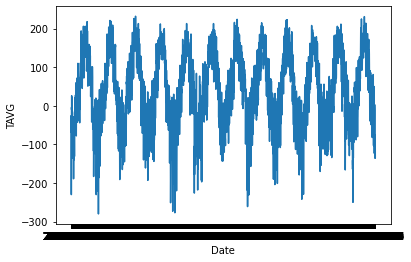

In [20]:
# testing to see what a station's weather looks like over 11 years
test_df = df_weather_years[df_weather_years['Station']=='USS0003E03S']

# plotting station USS0003E03S from 2010 to 2021
sns.lineplot(data=test_df, x='Date', y='TAVG')

In [21]:
# average over all of the US (not very meaningful, so I have commented it out)
# df_average_US_daily = df_weather_years.groupby('Date').mean()
# df_average_US_daily

In [22]:
def extract_day_of_year(df):
    '''
    adds Day of Year as a column to dataframe
    '''
    df['Day of Year'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.day_of_year
    
    return df

df_weather_years = extract_day_of_year(df_weather_years)
df_weather_years

,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation,lat,lon,name,admin1,admin2,cc,Day of Year
0,USS0003E03S,2010-01-01,-68.0,0.0,44.1100,-103.9800,2100.1,44.35221,-103.7652,Lead,South Dakota,Lawrence County,US,1
1,USS0003E05S,2010-01-01,-49.0,0.0,44.2100,-103.7900,1868.4,44.35221,-103.7652,Lead,South Dakota,Lawrence County,US,1
2,USS0004E07S,2010-01-01,-30.0,0.0,44.4900,-104.4100,1801.4,44.40637,-104.37578,Sundance,Wyoming,Crook County,US,1
3,USS0005G04S,2010-01-01,-53.0,25.0,42.4400,-105.8600,2552.7,42.86136,-105.87223,Glenrock,Wyoming,Converse County,US,1
4,USS0005G05S,2010-01-01,-38.0,25.0,42.2800,-105.5800,2407.9,42.75969,-105.38221,Douglas,Wyoming,Converse County,US,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485037,USW00094847,2021-12-31,34.0,0.0,42.2314,-83.3308,192.3,42.24087,-83.26965,Taylor,Michigan,Wayne County,US,365
4485038,USW00094849,2021-12-31,-3.0,0.0,45.0717,-83.5644,208.5,45.06168,-83.43275,Alpena,Michigan,Alpena County,US,365
4485039,USW00094860,2021-12-31,13.0,5.0,42.8939,-85.5447,237.1,42.94114,-85.61003,East Grand Rapids,Michigan,Kent County,US,365
4485040,USW00094908,2021-12-31,-23.0,0.0,42.3978,-90.7036,321.9,42.50056,-90.66457,Dubuque,Iowa,Dubuque County,US,365


<AxesSubplot:xlabel='Day of Year', ylabel='TAVG Across State'>

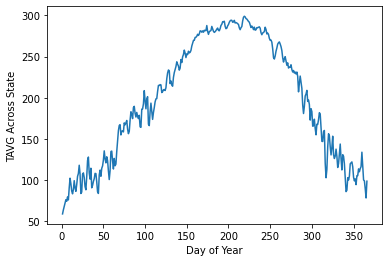

In [133]:
# get Texas weather and graph average over 2010-2021 years
df_weather_texas = df_weather_years[df_weather_years['admin1']=='Texas']
df_weather_texas_average = (
    df_weather_texas
    .groupby('Day of Year')[['TAVG']]
    .mean()
    .rename(columns={'TAVG': 'TAVG Across State'})
)

df_weather_texas_std = (
    df_weather_texas
    .groupby('Day of Year')[['TAVG']]
    .std()
    .rename(columns={'TAVG': 'STD Across State'})
)

sns.lineplot(data=df_weather_texas_average, x='Day of Year', y='TAVG Across State')

# https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
# TVG is in tenths of degrees C

In [134]:
# merge df_weather_texas so that it now has the TAVG Across State column,
# and is grouped by date
df_weather_texas_by_day = (
    df_weather_texas
    .merge(right=df_weather_texas_average, how='inner', on='Day of Year')
    .merge(right=df_weather_texas_std, how='inner', on='Day of Year')
    .groupby('Day of Year')[['TAVG Across State', 'STD Across State']]
    .mean()
)

# df_weather_texas_by_day holds the average temperature and standard
# deviation of a state (Texas) by Day of Year.
df_weather_texas_by_day

,TAVG Across State,STD Across State
Day of Year,,
1,58.883838,65.545208
2,63.817259,69.044847
3,67.903553,52.473471
4,71.791878,45.053736
5,76.157360,53.247694
...,...,...
362,100.142202,74.105996
363,99.041096,72.541119
364,89.438356,69.994165


In [135]:
df_weather_texas_by_date = (
    df_weather_texas
    .groupby('Date')[['TAVG']]
    .mean()
)

df_weather_texas_by_date

,TAVG
Date,
2010-01-01,60.500000
2010-01-02,88.000000
2010-01-03,100.000000
2010-01-04,74.000000
2010-01-05,37.000000
...,...
2021-12-27,195.130435
2021-12-28,196.217391
2021-12-29,183.869565


In [132]:
# We then merge the average temperature and standard deviation into the df_weather_texas
# such that we can calculate a z-score for each temperature for plotting crime

#INCOMPLETE
df_weather_texas = (
    df_weather_texas
    .merge(df_weather_texas_by_day, how='inner', on='Day of Year')
)

df_weather_texas

,Station,Date,TAVG,PRCP,Latitude,Longitude,Elevation,lat,lon,name,admin1,admin2,cc,Day of Year,TAVG Across State_x,STD Across State_x,TAVG Across State_y,STD Across State_y
0,USW00012923,2010-01-01,98.0,0.0,29.2733,-94.8592,1.5,29.30135,-94.7977,Galveston,Texas,Galveston County,US,1,58.883838,65.545208,58.883838,65.545208
1,USW00093904,2010-01-01,23.0,8.0,32.8167,-97.3500,214.9,32.85652,-97.33891,Blue Mound,Texas,Tarrant County,US,1,58.883838,65.545208,58.883838,65.545208
2,USW00012923,2011-01-01,153.0,0.0,29.2733,-94.8592,1.5,29.30135,-94.7977,Galveston,Texas,Galveston County,US,1,58.883838,65.545208,58.883838,65.545208
3,USW00093904,2011-01-01,32.0,0.0,32.8167,-97.3500,214.9,32.85652,-97.33891,Blue Mound,Texas,Tarrant County,US,1,58.883838,65.545208,58.883838,65.545208
4,USW00012923,2012-01-01,179.0,10.0,29.2733,-94.8592,1.5,29.30135,-94.7977,Galveston,Texas,Galveston County,US,1,58.883838,65.545208,58.883838,65.545208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78248,USW00023034,2020-12-31,16.0,236.0,31.3711,-100.4922,576.1,31.46377,-100.43704,San Angelo,Texas,Tom Green County,US,366,98.632653,63.667657,98.632653,63.667657
78249,USW00023044,2020-12-31,18.0,0.0,31.8111,-106.3758,1194.2,31.81357,-106.41224,Fort Bliss,Texas,El Paso County,US,366,98.632653,63.667657,98.632653,63.667657
78250,USW00023047,2020-12-31,-19.0,0.0,35.2333,-101.7089,1093.3,35.222,-101.8313,Amarillo,Texas,Potter County,US,366,98.632653,63.667657,98.632653,63.667657
78251,USW00093042,2020-12-31,-40.0,0.0,36.0167,-102.5500,1216.2,36.05948,-102.51325,Dalhart,Texas,Dallam County,US,366,98.632653,63.667657,98.632653,63.667657


In [153]:
df_simple_assault_Texas_by_date = (
    df_crime_data[(df_crime_data['UCR Offense Code']=='Simple Assault')
                  & (df_crime_data['State Code']==42)]
    .groupby('Incident Date')
    .size()

)                                 
df_simple_assault_Texas_by_date

Incident Date
2020-01-01    719
2020-01-02    342
2020-01-03    379
2020-01-04    480
2020-01-05    480
             ... 
2020-12-27    659
2020-12-28    535
2020-12-29    513
2020-12-30    440
2020-12-31    502
Length: 366, dtype: int64

TODO: I need to group by state in a better way, its a bit confusing right now as we need to combine both the stations and then the dates. I should have made a different dataframe, which we can make a new dataframe instead of modifying `df_weather_texas` the whole way through.